## Imports and helper functions

In [32]:
!pip install .

Defaulting to user installation because normal site-packages is not writeable
Processing /n/home07/adamaraju/fasrc/diffusers-t2i-adapter
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for diffusers: filename=diffusers-0.16.0.dev0-py3-none-any.whl size=877442 sha256=8540aab33f265b6e8703997a0ab8bb961f48f8c691e1bd00d376b9dc7266fa96
  Stored in directory: /n/home07/adamaraju/.cache/pip/wheels/3c/8b/ec/3a7ad4250255f19881dec9cb1fb244751e1c61a1c20f76a2d9
Successfully built diffusers
  Attempting uninstall: diffusers
    Found existing installation: diffusers 0.16.0.dev0
    Uninstalling diffusers-0.16.0.dev0:
      Successfully uninstalled diffusers-0.16.0.dev0


In [1]:
from transformers import CLIPFeatureExtractor, CLIPTextModel, CLIPTokenizer

from diffusers import (
    AutoencoderKL,
    T2IAdapter,
    MultiAdapter,
    StableDiffusionAdapterPipeline,
    DDPMScheduler
)

import torch
from torchvision import transforms
from torch.utils.data import Dataset
import torch.nn.functional as F
from tqdm.auto import tqdm
from diffusers.optimization import get_scheduler

/n/home07/adamaraju/.local/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [2]:
from types import SimpleNamespace
from datasets import load_dataset

#Generate an arg list 

args = SimpleNamespace()

#Dataset generation args
args.dataset_name = "fusing/fill50k"
args.train_data_dir = None #"../ControlNet/training/fill50k"
args.dataset_config_name=None
args.cache_dir = None
args.image_column = "image"
args.caption_column = "text"
args.conditioning_image_column = "conditioning_image"
args.resolution = 512
args.max_train_samples = 1000
args.seed = None
args.train_batch_size = 4
args.dataloader_num_workers = 0

#Training args
args.num_train_epochs = 200
args.max_train_steps = 1000
args.gradient_accumulation_steps = 1
args.do_classifier_free_guidance= False
args.validation_steps = 1
args.set_grads_to_none = False
#learning rate
args.lr_scheduler = "constant"
args.lr_num_cycles = 1
args.lr_power = 1
args.lr_warmup_steps = 500
args.lr = 1e-5

#Validation args
args.seed = None

#adapter args
args.adapter_conditioning_scale = 1.0
args.num_images_per_prompt = 1

## Generate training dataset

### Generate base images first

In [3]:
import numpy as np
import cv2

def generate_centered_square(H, W, square_side_length):
    # Create a blank image
    image = np.zeros((H, W), dtype=np.uint8)
    
    # Determine the center coordinates
    center_x = W // 2
    center_y = H // 2
    
    # Calculate the start and end coordinates for the square
    start_x = center_x - square_side_length // 2
    start_y = center_y - square_side_length // 2
    end_x = start_x + square_side_length
    end_y = start_y + square_side_length
    
    # Set the square region to ones
    image[start_y:end_y, start_x:end_x] = 1
    
    return image

def generate_centered_triangle(H, W, triangle_side_length):
    # Create a blank image
    image = np.zeros((H, W), dtype=np.uint8)
    
    # Determine the center coordinates
    center_x = W // 2
    center_y = H // 2
    
    # Calculate the half side length of the triangle
    half_side_length = triangle_side_length // 2
    
    # Calculate the three vertex coordinates of the triangle
    vertex1 = (center_x, center_y - half_side_length)
    vertex2 = (center_x - half_side_length, center_y + half_side_length)
    vertex3 = (center_x + half_side_length, center_y + half_side_length)
    
    # Draw the triangle on the image
    points = np.array([vertex1, vertex2, vertex3], np.int32)
    cv2.fillPoly(image, [points], 1)
    
    return image

def generate_centered_circle(H, W, circle_radius):
    # Create a blank image
    image = np.zeros((H, W), dtype=np.uint8)
    
    # Determine the center coordinates
    center_x = W // 2
    center_y = H // 2
    
    # Draw the circle on the image
    cv2.circle(image, (center_x, center_y), circle_radius, 1, thickness=-1)
    
    return image

H = 512
W = 512
square_side_length = 150
triangle_side_length = 150
circle_radius = 100

In [4]:
import torch
import torch.optim as optim
from random import shuffle
# Define the binary maps for the two squares
# You can replace these with your own image data
H = 512
W = 512
image = torch.zeros(H, W, dtype = torch.float32)

# Determine the square dimensions and center coordinates
square_size = 200
center_x = image.size(1) // 2
center_y = image.size(0) // 2

# Calculate the start and end indices for the square
start_x = center_x - square_size // 2
start_y = center_y - square_size // 2
end_x = start_x + square_size
end_y = start_y + square_size

# Set the square region to ones
image[start_y:end_y, start_x:end_x] = 1

im1 = torch.tensor(generate_centered_square(H, W, square_side_length),dtype = torch.float32)
im2 = torch.tensor(generate_centered_triangle(H, W, triangle_side_length),dtype = torch.float32)
im3 = torch.tensor(generate_centered_circle(H, W, circle_radius),dtype = torch.float32)
shapes = [im1,im2,im3]
shuffle(shapes)
#HARD CODE NUMBER OF IMAGES FOR NOW (can easily change later if needed)


from torch.nn import functional as F
def apply_rotation_and_translation(image_tensor, rotation_angle,translation_x,translation_y):
    # Create the affine transformation matrix
    theta = torch.stack([torch.cos(rotation_angle), -torch.sin(rotation_angle),translation_x,
                         torch.sin(rotation_angle), torch.cos(rotation_angle),translation_y]).reshape(2, 3)
    
    # Apply the rotation transformation using grid_sample
    image_tensor = image_tensor.unsqueeze(0).unsqueeze(0)
    grid = F.affine_grid(theta.unsqueeze(0), image_tensor.size())
    rotated_image_tensor = F.grid_sample(image_tensor, grid)
    
    return rotated_image_tensor.squeeze(0)

# Define the overlap function
def compute_overlap(im1, im2, rotation, translation_x, translation_y):
    # Apply rotation and translation transformations to square2
    im2_t = apply_rotation_and_translation(im2, rotation,translation_x,translation_y)
    
    # Compute the element-wise intersection of the two squares
    intersection = torch.multiply(im1, im2_t)
    union = im1+im2_t - intersection
    # Compute the overlap as a percentage of the total area
    overlap = intersection.sum() / im1.sum()
    return overlap,union

# Define the loss function
def loss_function(overlap,min=True):
    # Set the target overlap range
    if min:
      target_min = 0.3
    else:
      target_min = 0
    target_max = 0.45

    # Compute the loss using tensor operations
    loss =  (torch.clamp(overlap, target_min, target_max)-overlap)**2
    return loss

# Set the learning rate and number of optimization steps
def space_masks(shapes):
  '''
  Given a list of initial masks, space them out and decide if they are valid
  '''
  NUM_SHAPES = len(shapes)

  # Initialize the rotation and translation parameters
  init_params = torch.rand([NUM_SHAPES-1,3])*.1
  rotation = init_params[:,0].clone().requires_grad_(True)
  translation_x = init_params[:,1].clone().requires_grad_(True)
  translation_y = init_params[:,2].clone().requires_grad_(True)


  learning_rate = .1
  num_steps = 60

  # Create an optimizer
  optimizer = optim.SGD([rotation, translation_x, translation_y], lr=learning_rate)

  # Optimization loop
  valid = False
  for step in range(num_steps):
      overlaps = []
      optimizer.zero_grad() 
      loss = torch.tensor(0.0)
      for idx in range(NUM_SHAPES - 1):
        if idx == 0:
          overlap,union = compute_overlap(shapes[idx], shapes[idx+1], rotation[idx], translation_x[idx], translation_y[idx])
          loss = loss +  loss_function(overlap)
          overlaps.append(overlap.item())
        else:
          for j in range(idx+1):
            overlap,union = compute_overlap(shapes[j], shapes[idx+1], rotation[idx], translation_x[idx], translation_y[idx])
            loss = loss +  loss_function(overlap,(j-idx==1))
            overlaps.append(overlap.item())
      loss.backward()
      optimizer.step()

      # Print the progress
      # if (step % (num_steps/10) == 0):
        # print(f"Step [{step+1}/{num_steps}], Loss: {loss.item()}, Overlap: {overlaps}")
      if loss < 1e-1:
        valid = True
        # print(f"Complete on step {step}, with overlap {overlaps}")
        break
  out_shapes = [shapes[0]]
  for idx in range(NUM_SHAPES - 1):
    out_shapes.append(apply_rotation_and_translation(shapes[idx+1], rotation[idx],translation_x[idx],translation_y[idx])[0,...].detach())
  # for idx in len(out_shapes):
  #   out_shapes[idx] = 1 - out_shapes[idx]
  return out_shapes,valid


# Next step, make random colors, r g and b for the three shapes and assign them

import torch
import torch.nn.functional as F

def color_mask(binary_mask, color):
    """
    Fill a binary mask with the specified color.

    Args:
        binary_mask (torch.Tensor): Binary mask tensor of shape (H, W) where H is the height and W is the width.
        color (str): Candidate color - 'red', 'green', or 'blue'.

    Returns:
        torch.Tensor: Image tensor of shape (3, H, W) with the filled color based on the binary mask.
    """
    # Validate the color input
    valid_colors = ['red', 'green', 'blue']
    if color not in valid_colors:
        raise ValueError("Invalid color. Choose from 'red', 'green', or 'blue'.")

    # Expand the binary mask to have 3 channels for RGB
    mask_rgb = binary_mask.unsqueeze(0).repeat(3, 1, 1)

    # Define the color channels
    if color == 'red':
        color_channels = torch.tensor([1.0, 0.0, 0.0], dtype=torch.float32).view(3, 1, 1)
    elif color == 'green':
        color_channels = torch.tensor([0.0, 1.0, 0.0], dtype=torch.float32).view(3, 1, 1)
    else:  # color == 'blue'
        color_channels = torch.tensor([0.0, 0.0, 1.0], dtype=torch.float32).view(3, 1, 1)

    # Fill the mask with the specified color
    filled_image = mask_rgb * color_channels + 1-mask_rgb

    return filled_image


import random

def generate_canonical_shapes():
  H = 512
  W = 512
  square_side_length = 150
  triangle_side_length = 150
  circle_radius = 100

  im1 = torch.tensor(generate_centered_square(H, W, square_side_length),dtype = torch.float32)
  im2 = torch.tensor(generate_centered_triangle(H, W, triangle_side_length),dtype = torch.float32)
  im3 = torch.tensor(generate_centered_circle(H, W, circle_radius),dtype = torch.float32)
  shapes = [im1,im2,im3]
  random.shuffle(shapes)
  NUM_SHAPES = 2
  masks, valid = space_masks(shapes)
  if not valid:
    print("invalid!")
  final_out = None
  colors = ['red','green','blue']
  polygons = []
  random.shuffle(colors)
  for idx in np.arange(NUM_SHAPES):
    if final_out == None:
      polygon = color_mask(masks[idx],colors[idx])
      polygons.append(polygon.clone().permute(1,2,0))
      final_out = polygon
    else:
      bool_tensor = masks[idx]>.5
      polygon = color_mask(masks[idx],colors[idx])
      polygons.append(polygon.permute(1,2,0))
      final_out[:,bool_tensor] = polygon[:,bool_tensor]

  final_out = final_out.permute(1,2,0)
  return final_out,[mask.unsqueeze(-1) for mask in masks],polygons


In [5]:
DATASET_SIZE=200
H=W=512

layer_binaries = []
layer_imgs = []
base_imgs = []

for itr in range(DATASET_SIZE):
    img,masks,polygons = generate_canonical_shapes()
    
    layer_binaries.append(masks)
    layer_imgs.append(polygons)
    base_imgs.append(img)
    # print(itr)
    if itr%200 == 0:
        print(itr)

/n/home07/adamaraju/.local/lib/python3.8/site-packages/torch/nn/functional.py:4298: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/n/home07/adamaraju/.local/lib/python3.8/site-packages/torch/nn/functional.py:4236: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


0


In [6]:
def combine_masks(binary_masks, index):
    '''
    input: binary_masks, size B x Layers x C x H x W
    '''
    
    combined_list = []
    for batch_id in range(binary_masks.shape[0]):
        combined_mask = torch.zeros_like(binary_masks[0,0,...], dtype=torch.uint8)
        for i in range(index):
            combined_mask = torch.logical_or(combined_mask, binary_masks[batch_id,i,...])
        combined_list.append(combined_mask)
    return torch.stack(combined_list)


# combined_mask = combine_masks(torch.tensor(masks).squeeze().unsqueeze(0),2)

# plt.imshow(combined_mask.squeeze(),cmap='gray')

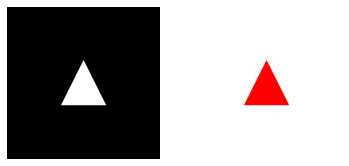

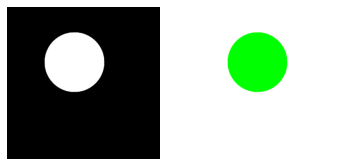

In [8]:
from matplotlib import pyplot as plt
for mask,polygon in zip(masks,polygons):
    plt.figure()
    plt.subplot(121)
    plt.imshow(mask,cmap='gray')
    plt.axis('off')
    
    plt.subplot(122)
    plt.imshow(polygon)
    plt.axis('off')

In [9]:
# # Also need to generate some utils for the training for the layering maps
# # For example need some code that combines all layer maps below a layer and all above a layer
# # Also need analagous code that does this for the layered  objects in the image

# def get_front_layers(layer_imgs, layer_bin, layer_no):
#     num_layers = len(layer_imgs) -1 #subtract 1 for loops??
#     front_layers = np.ones(layer_imgs[0].shape)
#     front_bin = np.zeros(layer_bin.shape)
#     if layer_no == num_layers:
#         return front_layers,front_bin
#     else:
#         for layer_idx in range(layer_no,num_layers):
#             front_layers[layer_bin==1,:] = layer_imgs[layer_bin==1,:]
#             front_bin[layer_bin==1] = 1
#         return front_layers,front_bin
        

# def get_back_layer(layer_imgs, layer_bin, layer_no):
#     num_layers = len(layer_imgs) - 1
#     back_layers = np.ones(layer_imgs[0].shape)
#     back_bin = np.zeros(layer_bin.shape)
#     for layer_idx in range(layer_no):
#         #FINISH / FIX THIS CODE AT SOMEPOINT
#         front_layers[layer_bin==1,:] = layer_imgs[layer_bin==1,:]
#         front_bin[layer_bin==1] = 1
#     return front_layers,front_bin

### Put data into dataset objects

In [10]:
#Define image transforms

image_transforms = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.Resize(args.resolution, interpolation=transforms.InterpolationMode.BILINEAR),
        transforms.CenterCrop(args.resolution),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)

conditioning_image_transforms = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.Resize(args.resolution, interpolation=transforms.InterpolationMode.BILINEAR),
        transforms.CenterCrop(args.resolution),
        transforms.ToTensor(),
    ]
)

In [11]:
# Create a dataset class
class LayerDataset(Dataset):
    def __init__(self,base_imgs,layer_imgs,layer_binaries):
        self.data = list(zip(base_imgs,layer_imgs,layer_binaries))
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        prompt = 'an object on a black background'

        source = item[0] #original (base) image
        targets = item[1] #Layerwise images
        masks = item[2] #Layerwise black and white binaries
        
        #Convert to torch tensors and apply image transforms
        source = torch.tensor(source).permute(2,0,1)
        source = conditioning_image_transforms(source)

        target_list = []
        for target in targets:
            target_list.append(image_transforms(255*torch.tensor(target).permute(2,0,1)))
        target_tensor = torch.stack(target_list)
        
        mask_list = []
        for mask in masks:
            mask_list.append(conditioning_image_transforms(255*torch.tensor(mask).permute(2,0,1)))
        mask_tensor = torch.stack(mask_list)

        return dict(pixel_values=target_tensor, pixel_binaries =mask_tensor,  txt=prompt, conditioning_pixel_values=source)

In [12]:
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    pixel_values = pixel_values.to(memory_format=torch.contiguous_format).float()

    conditioning_pixel_values = torch.stack([example["conditioning_pixel_values"] for example in examples])
    conditioning_pixel_values = conditioning_pixel_values.to(memory_format=torch.contiguous_format).float()

    pixel_binaries = torch.stack([example["pixel_binaries"] for example in examples])
    pixel_binaries = pixel_binaries.to(memory_format=torch.contiguous_format).float()
    # input_ids = torch.stack([example["input_ids"] for example in examples])

    return {
        "pixel_values": pixel_values,
        "conditioning_pixel_values": conditioning_pixel_values,
        "pixel_binaries": pixel_binaries,
        # "input_ids": input_ids,
    }


In [13]:
train_dataset =  LayerDataset(base_imgs,layer_imgs,layer_binaries)

# plt.subplot(121)
# plt.imshow(train_dataset[0]['pixel_values'].permute(1,2,0)/ 2 + 1/2)

# plt.subplot(122)
# plt.imshow(train_dataset[0]['conditioning_pixel_values'].permute(1,2,0))

In [14]:
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    shuffle=True,
    collate_fn=collate_fn,
    batch_size=args.train_batch_size,
    num_workers=args.dataloader_num_workers,
)

### Create a subset of validation images

In [15]:
!nvidia-smi

Tue Aug  8 10:55:10 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.54.03              Driver Version: 535.54.03    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-80GB          On  | 00000000:CA:00.0 Off |                    0 |
| N/A   23C    P0              55W / 500W |      8MiB / 81920MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [16]:
VALIDATION_SIZE=2
H=W=512

val_binaries = []
val_layers = []
val_imgs = []

for itr in range(VALIDATION_SIZE):
    img,masks,polygons = generate_canonical_shapes()
    
    #add to lists
    val_binaries.append(masks)
    val_layers.append(polygons)
    val_imgs.append(img)
    
#     if itr%200 == 0:
#         print(itr)

/n/home07/adamaraju/.local/lib/python3.8/site-packages/torch/nn/functional.py:4298: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/n/home07/adamaraju/.local/lib/python3.8/site-packages/torch/nn/functional.py:4236: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


In [17]:
from PIL import Image

val_imgs_PIL = []
val_layers_PIL = []
for idx in range(len(val_imgs)):
    rint = 0#np.random.randint(0,3)
    val_imgs_PIL.append(Image.fromarray((val_imgs[idx]*255).numpy().astype(np.uint8)))
    # val_imgs_PIL.append([Image.fromarray((val_imgs[idx]*255).numpy().astype(np.uint8)), Image.fromarray((val_binaries[idx][rint]*255).repeat(1,1,3).numpy().astype(np.uint8))])
    val_layers_PIL.append(Image.fromarray(255*val_layers[idx][rint].numpy().astype(np.uint8)))
    
transform = transforms.Compose([transforms.PILToTensor()])
val_set = []
for imgs in val_imgs_PIL:
    val_set.append(imgs)
    # val_set.append(torch.cat([transform(img) for img in imgs],dim=0).unsqueeze(0))
    
args.validation_image = val_set
args.validation_prompt = ["picture of an object on a black background"]
args.num_validation_images = VALIDATION_SIZE

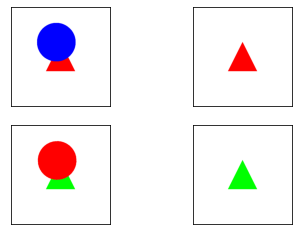

In [18]:
## Hard code some things for getting the first layer of each val_layers for now

plt.subplot(221)
plt.imshow(val_imgs_PIL[0])
plt.xticks([]);plt.yticks([]);

plt.subplot(222)
plt.imshow(val_layers_PIL[0])
plt.xticks([]);plt.yticks([]);

plt.subplot(223)
plt.imshow(val_imgs_PIL[1])
plt.xticks([]);plt.yticks([]);

plt.subplot(224)
plt.imshow(val_layers_PIL[1])
plt.xticks([]);plt.yticks([]);

In [19]:
# conditioning_image_transforms(np.array(val_imgs_PIL[0]))

## Implement the adapter models

In [20]:
import torch
import torch.nn as nn

## Network that takes 4 dimensional input and pushes it to 3 dimensions for the vae
class ContractNet(nn.Module):
    def __init__(self):
        super(ContractNet, self).__init__()
        self.conv = nn.Conv2d(4, 3, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

    

## Network that takes 3 dimensional input and pushes it to 4 dimensions for model out
class ExpandNet(nn.Module):
    def __init__(self):
        super(ExpandNet, self).__init__()
        self.conv = nn.Conv2d(3, 4, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


In [21]:
#Instantiate the two adapters and the pretrained model

# An adapter that takes in the original image (or a subset of layers)
RGB_adapter = T2IAdapter(channels_in=int(3), 
                       block_out_channels=[320, 640, 1280, 1280][:4], 
                       num_res_blocks=2, 
                       kernel_size=1, 
                       res_block_skip=True, 
                       use_conv=False)

# An adapter that takes in the mask given by the layers above the current one
mask_adapter = T2IAdapter(channels_in=int(3), 
                       block_out_channels=[320, 640, 1280, 1280][:4], 
                       num_res_blocks=2, 
                       kernel_size=1, 
                       res_block_skip=True, 
                       use_conv=False)

#Combine them into a single adapter
adapter = MultiAdapter([RGB_adapter,mask_adapter])
# adapter = RGB_adapter

#Instantiate the Convolutional layers
# contract_layer = ContractNet()
# expand_layer = ExpandNet()

#Pretrained stable diffusion model that we will try not to touch (may end up changing the final conv_out though.
#To be honest I am really hoping this works

model_name = "runwayml/stable-diffusion-v1-5"
pipe = StableDiffusionAdapterPipeline.from_pretrained(model_name, torch_dtype=torch.float32).to('cuda')
pipe.safety_checker = None

vae = pipe.vae
unet = pipe.unet
noise_scheduler = DDPMScheduler.from_pretrained(model_name, subfolder="scheduler")

## Not sure, do i turn off gradients for these networks? Probaly not in my optinion
# vae.requires_grad_(False)
# unet.requires_grad_(False)
# text_encoder.requires_grad_(False)
# also get the clip model because it matters probably....

#But looks like it may not work as just the model for training so we have to separate it into parts for training anyway

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


In [ ]:
#Random point, what if I dont do anything about the masking etc, and just try and make a model that removes the top object in a scene, or like just tries to get the layer mappings?

## Train the model

### TODO: Write a validation loop

In [22]:
def log_validation(pipe, adapter, args, step=0,accelerator=None):
    print(f"step = {step}")

    # controlnet = accelerator.unwrap_model(controlnet)

    pipe.adapter = adapter
    # print(pipe.adapter.num_adapter)
    # pipeline.scheduler = UniPCMultistepScheduler.from_config(pipeline.scheduler.config)
    # pipeline = pipeline.to(accelerator.device)
    # pipeline.set_progress_bar_config(disable=True)

#     if args.enable_xformers_memory_efficient_attention:
#         pipeline.enable_xformers_memory_efficient_attention()

    if args.seed is None:
        generator = None
    else:
        generator = torch.Generator(device=accelerator.device).manual_seed(args.seed)

    if len(args.validation_image) == len(args.validation_prompt):
        validation_images = args.validation_image
        validation_prompts = args.validation_prompt
    elif len(args.validation_image) == 1:
        validation_images = args.validation_image * len(args.validation_prompt)
        validation_prompts = args.validation_prompt
    elif len(args.validation_prompt) == 1:
        validation_images = args.validation_image
        validation_prompts = args.validation_prompt * len(args.validation_image)
    else:
        raise ValueError(
            "number of `args.validation_image` and `args.validation_prompt` should be checked in `parse_args`"
        )

    image_logs = []

    for validation_prompt, validation_image in zip(validation_prompts, validation_images):
        # validation_image = Image.open(validation_image).convert("RGB")

        images = []

        for _ in range(args.num_validation_images):
            # print(validation_image)
            # print([preprocess(img) for img in validation_image.unsqueeze(0)][0].shape)
            with torch.autocast("cuda"):
                image = pipe(
                    validation_prompt, validation_image, num_inference_steps=20, generator=generator,adapter_weighting = args.adapter_weighting
                ).images[0]

            images.append(image)

        image_logs.append(
            {"validation_image": validation_image, "images": images, "validation_prompt": validation_prompt}
        )
    return image_logs

# Here I need to make a set of images 
# Looks like top row, validation image *2, next validation image *2, bottom row is outputs

def save_image_logs(image_logs,step=0):
    plt.figure()
    plt.subplot(241)
    plt.imshow(image_logs[0]['validation_image'])
    plt.subplot(242)
    plt.imshow(image_logs[0]['validation_image'])
    plt.subplot(243)
    plt.imshow(image_logs[1]['validation_image'])
    plt.subplot(244)
    plt.imshow(image_logs[1]['validation_image'])

    plt.subplot(245)
    plt.imshow(image_logs[0]['images'][0])
    plt.subplot(246)
    plt.imshow(image_logs[0]['images'][1])
    plt.subplot(247)
    plt.imshow(image_logs[1]['images'][0])
    plt.subplot(248)
    plt.imshow(image_logs[1]['images'][1])

    plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]);

    plt.savefig(f'test_logs/debug_tests/canonical_training_epoch_{step}_val.png')

In [23]:
# image_logs = log_validation(pipe, adapter, args)
# save_image_logs(image_logs)

### Actual training loop

In [24]:
from src.diffusers.models.modeling_utils import ModelMixin
from typing import List, Optional

class MultiAdapter(ModelMixin):
    r"""
    MultiAdapter is a wrapper model that contains multiple adapter models and merges their outputs according to
    user-assigned weighting.

    This model inherits from [`ModelMixin`]. Check the superclass documentation for the generic methods the library
    implements for all the model (such as downloading or saving, etc.)

    Parameters:
        adapters (`List[T2IAdapter]`, *optional*, defaults to None):
            A list of `T2IAdapter` model instances.
    """

    def __init__(self, adapters: List[T2IAdapter]):
        super(MultiAdapter, self).__init__()

        self.num_adapter = len(adapters)
        self.adapters = nn.ModuleList(adapters)

    def forward(self, xs: torch.Tensor, adapter_weights: Optional[List[float]] = None, train = False) -> List[torch.Tensor]:
        r"""
        Args:
            xs (`torch.Tensor`):
                (batch, channel, height, width) input images for multiple adapter models concated along dimension 1,
                `channel` should equal to `num_adapter` * "number of channel of image".
            adapter_weights (`List[float]`, *optional*, defaults to None):
                List of floats representing the weight which will be multiply to each adapter's output before adding
                them together.
        """
        if adapter_weights is None:
            adapter_weights = torch.tensor([1 / self.num_adapter] * self.num_adapter)
        else:
            adapter_weights = torch.tensor(adapter_weights)
        if train == False:
            xs = xs.flatten(0,1).unsqueeze(0)
        if xs.shape[1] % self.num_adapter != 0:
            raise ValueError(
                f"Expecting multi-adapter's input have number of channel that cab be evenly divisible "
                f"by num_adapter: {xs.shape[1]} % {self.num_adapter} != 0"
            )
        x_list = torch.chunk(xs, self.num_adapter, dim=1)
        accume_state = None
        for x, w, adapter in zip(x_list, adapter_weights, self.adapters):
            features = adapter(x)
            if accume_state is None:
                accume_state = features
            else:
                for i in range(len(features)):
                    accume_state[i] = accume_state[i] + w * features[i]
        return accume_state


In [25]:
RGB_adapter = T2IAdapter(channels_in=int(3), 
                       block_out_channels=[320, 640, 1280, 1280][:4], 
                       num_res_blocks=2, 
                       kernel_size=1, 
                       res_block_skip=True, 
                       use_conv=False)

# An adapter that takes in the mask given by the layers above the current one
mask_adapter = T2IAdapter(channels_in=int(3), 
                       block_out_channels=[320, 640, 1280, 1280][:4], 
                       num_res_blocks=2, 
                       kernel_size=1, 
                       res_block_skip=True, 
                       use_conv=False)

#Combine them into a single adapter

# adapter = MultiAdapter([RGB_adapter,mask_adapter])
# adapters = [RGB_adapter,mask_adapter]

adapter = RGB_adapter

In [26]:
#Put adapter on GPU
# for adapter in adapters:
adapter = adapter.to("cuda")
adapter.train()

#Set optimizer class
optimizer_class = torch.optim.AdamW

#Get parameters to optimize
# params_to_optimize = list(adapters[0].parameters()) + list(adapters[1].parameters())
params_to_optimize = adapter.parameters()
optimizer = optimizer_class(
    params_to_optimize,
    lr = args.lr
) 

#Get lr scheduler = 
lr_scheduler = get_scheduler(
    args.lr_scheduler,
    optimizer=optimizer,
    num_warmup_steps=args.lr_warmup_steps,# * args.gradient_accumulation_steps,
    num_training_steps=args.max_train_steps,# * args.gradient_accumulation_steps,
    num_cycles=args.lr_num_cycles,
    power=args.lr_power,
)

# additional, try to figure out accelerator

In [28]:
vae.requires_grad_(False);
args.adapter_weighting = [1.0,0.7]
# unet.requires_grad_(False);

***** Running training *****
  Num examples = 200
  Num batches each epoch = 50
  Num Epochs = 200
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 1
  Total optimization steps = 10000


Steps:   0%|          | 0/10000 [00:00<?, ?it/s]

<ipython-input-11-b3266674a631>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  source = torch.tensor(source).permute(2,0,1)
<ipython-input-11-b3266674a631>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_list.append(image_transforms(255*torch.tensor(target).permute(2,0,1)))
<ipython-input-11-b3266674a631>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask_list.append(conditioning_image_transforms(255*torch.tensor(mask).permute(2,0,1)))


{'loss': 0.0012628622353076935, 'lr': 1e-05}
step = 0


/n/home07/adamaraju/.local/lib/python3.8/site-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion_adapter.py:698: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  num_channels_latents = self.unet.in_channels


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.001889253268018365, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.0010624179849401116, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.0006349455215968192, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.0005183124449104071, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.0015904468018561602, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.00010696140088839456, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.00011402968812035397, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.00040147709660232067, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.00015636018360964954, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.00010191546607529745, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.0007419028552249074, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.0012256086338311434, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.00015801613335497677, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.0005750501877628267, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.00036925854510627687, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.0010630711913108826, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 8.515563240507618e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.0019465973600745201, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.0007171363686211407, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

<ipython-input-22-a6fcc43b55e8>:60: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


{'loss': 9.071880776900798e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.00010701072460506111, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.00034985964884981513, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.0002236357395304367, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.0006310037570074201, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.0006849197088740766, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.00023963800049386919, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 4.624794382834807e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 4.16403345298022e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.0006519851158373058, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.0009437203407287598, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.00016742307343520224, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.00014389745774678886, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.00026388518745079637, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 4.426835948834196e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.0005791099974885583, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 6.683109677396715e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.0007512700976803899, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.00010148316505365074, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.00012263236567378044, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.0006005312316119671, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 7.768755313009024e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.00014043482951819897, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.8322318030404858e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.0016169172013178468, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.0006194845191203058, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.00015930357039906085, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 8.067278395174071e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 8.775312744546682e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.00035540718818083405, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 9.16868302738294e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.0003263756516389549, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.00025325920432806015, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 8.283244824269786e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 4.9012480303645134e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 6.180930358823389e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 7.94313382357359e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.0001301660086028278, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.0005620429874397814, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.00015763341798447073, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.00019785550830420107, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 8.758118929108605e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.00011746434029191732, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 7.165793795138597e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 4.382802580948919e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 9.03265317901969e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 7.663914584554732e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 9.464441245654598e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.00011594688112381846, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 5.2128649258520454e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.0002808487042784691, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.0009237228077836335, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 5.0729264330584556e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.0004149512969888747, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.0002140779106412083, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 5.183845496503636e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.00012124878412578255, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 3.9130976801970974e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.00014579556591343135, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.0034795047249644995, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 8.449749293504283e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 9.907510684570298e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.00010157242650166154, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.0001074698448064737, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 8.180148870451376e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.00010392750846222043, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.00023720036551821977, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.00047228531911969185, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 5.7232122344430536e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.00014835498586762697, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 7.329456275328994e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.0004995465278625488, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.00024358935479540378, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.0002504248986952007, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 3.8685153413098305e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 3.165873931720853e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 5.50488693988882e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.00024865649174898863, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.00018666530377231538, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 8.271678234450519e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 5.19186542078387e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.00013757639680989087, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.00011112432548543438, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.00013209899771027267, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.4316992494277656e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.00013365464110393077, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.00012115824210923165, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.0008677940350025892, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 5.401171074481681e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.0013158895308151841, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 3.750239193323068e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.00010495276364963502, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.0003751430194824934, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 3.8119520468171686e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.00019750578212551773, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.001023696968331933, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 4.077993071405217e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 8.7779073510319e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.00014420445950236171, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.000167362522915937, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.0007361247553490102, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.0001876563619589433, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.00028299581026658416, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 5.8174075093120337e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.0003030389780178666, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.297818718943745e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 4.5924192818347365e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.0005341051146388054, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 9.667523409007117e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 8.722244820091873e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.608409704407677e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 7.092629675753415e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.00012647408584598452, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 3.131169069092721e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 5.197814607527107e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.00010192336776526645, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.00018523028120398521, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 6.476524140452966e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.00018217842443846166, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 5.23855778737925e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 7.892062421888113e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.001111594378016889, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.0005852311151102185, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 5.214581688051112e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.0004785135970450938, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.00015757058281451464, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 4.741500015370548e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.0005381345981732011, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 4.850350524066016e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 3.837625990854576e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 1.9937117031076923e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 7.528871356043965e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 4.587950388668105e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 7.963575626490638e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 4.937441190122627e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 3.287118306616321e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 3.0418188543990254e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 7.797236321493983e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 7.491643918910995e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.00011246191570535302, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.00011708195961546153, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.00010898710752371699, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.4925368052208796e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.0001702145382296294, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.6158933906117454e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.7583297196542844e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.0007831163820810616, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 8.097371755866334e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 4.1542938561178744e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 3.698576256283559e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 8.824621909298003e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.0006596617167815566, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 9.758636588230729e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 3.158461186103523e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.00010591042519081384, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.0009793635690584779, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.001490047201514244, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 9.156184387393296e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 2.4575352654210292e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.00019133448950015008, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 3.0500781576847658e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.0002062534767901525, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 4.4876323954667896e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.0002832431928254664, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.00019691228226292878, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.00019540284120012075, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.0001895134337246418, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 9.167132520815358e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 4.052210715599358e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.00010506460967008024, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.0008798729395493865, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 5.3500221838476136e-05, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'loss': 0.0001279084535781294, 'lr': 1e-05}
step = 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

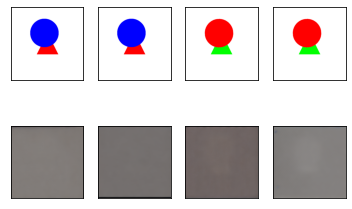

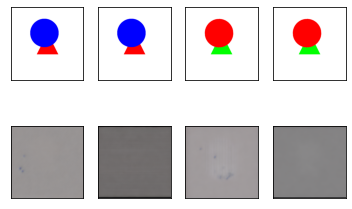

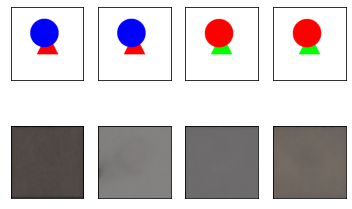

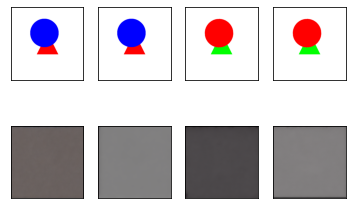

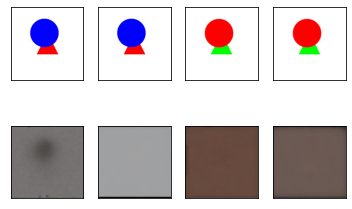

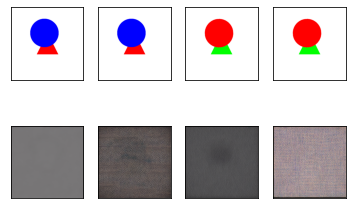

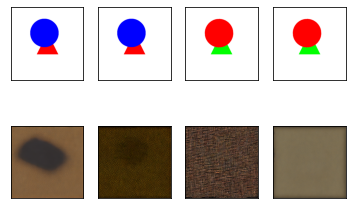

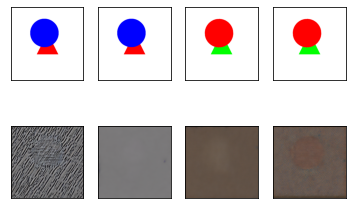

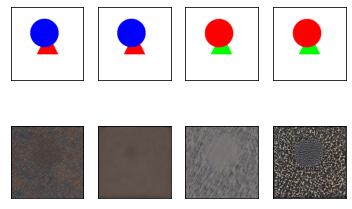

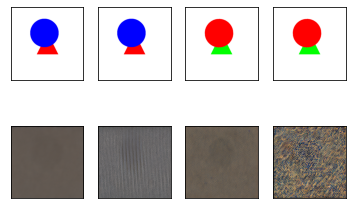

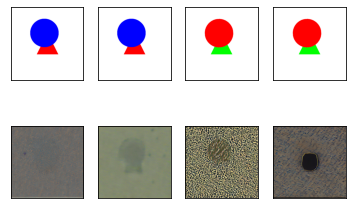

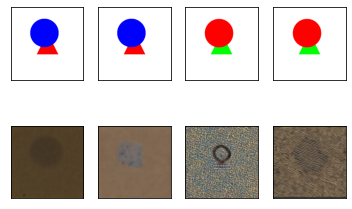

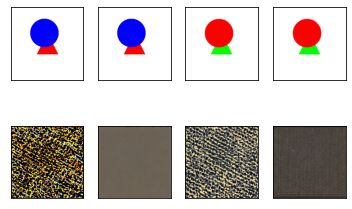

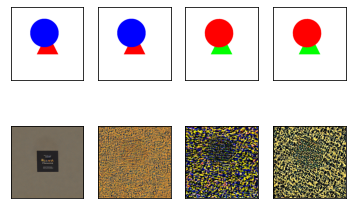

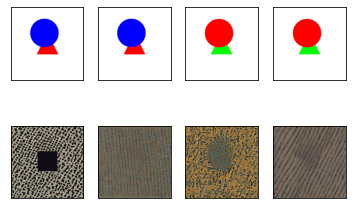

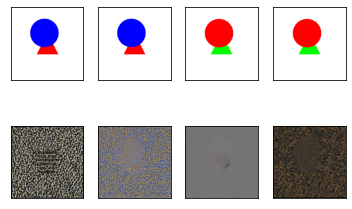

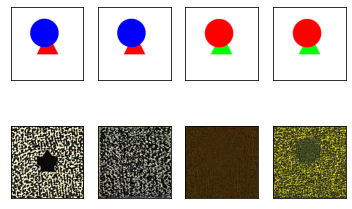

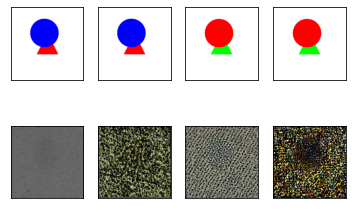

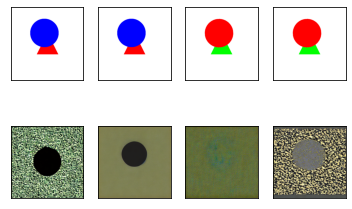

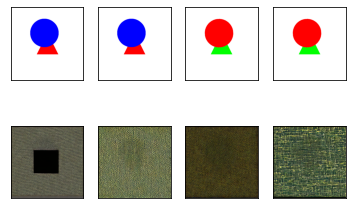

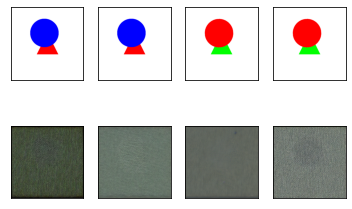

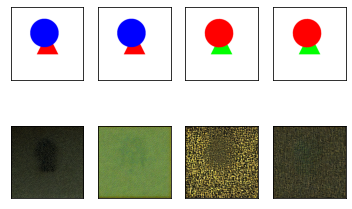

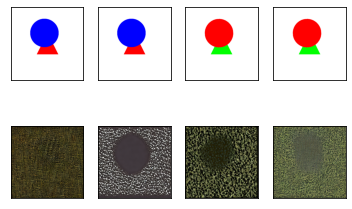

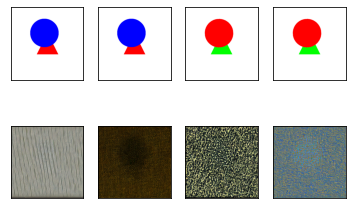

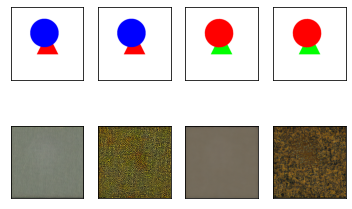

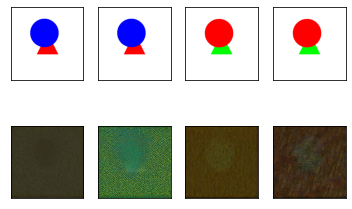

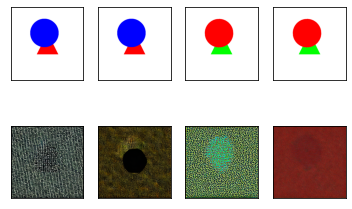

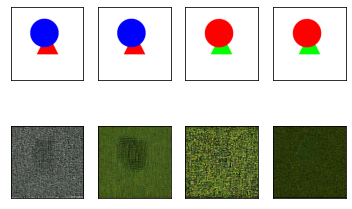

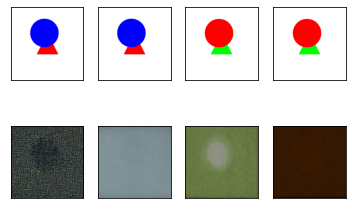

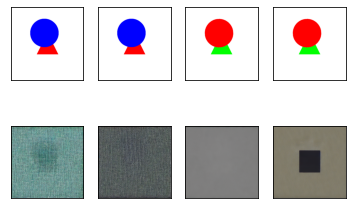

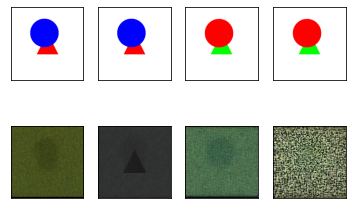

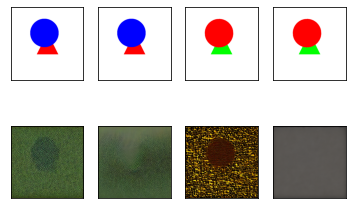

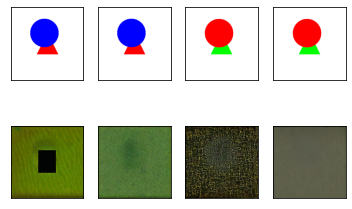

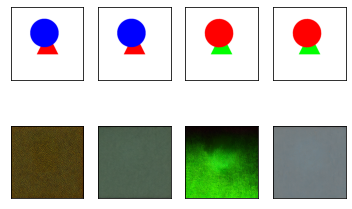

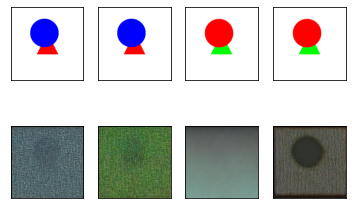

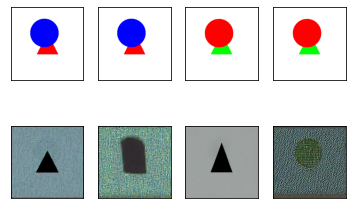

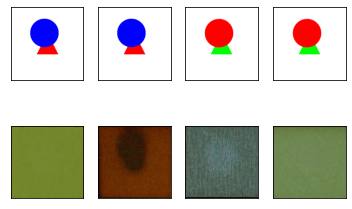

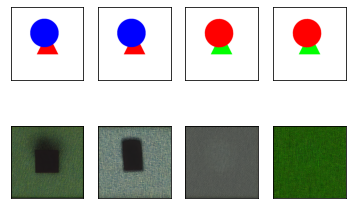

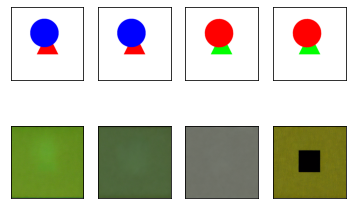

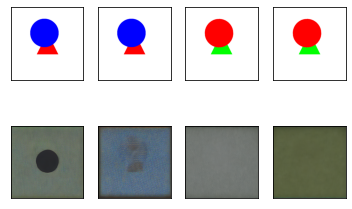

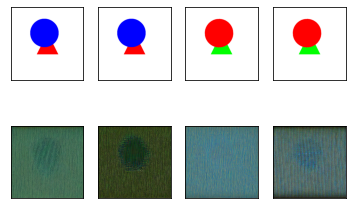

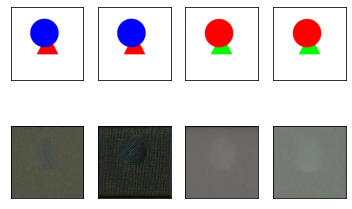

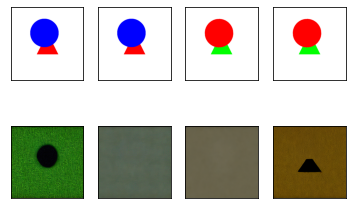

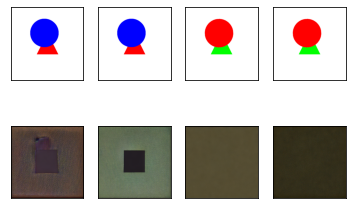

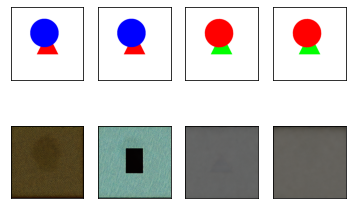

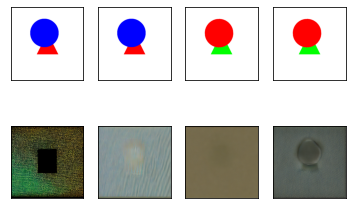

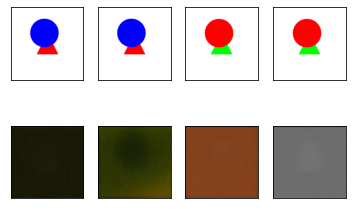

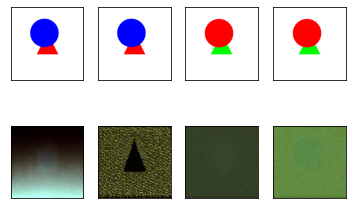

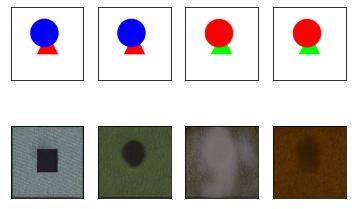

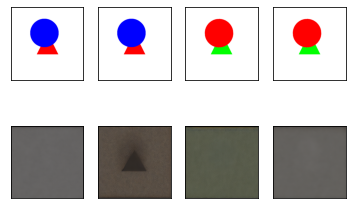

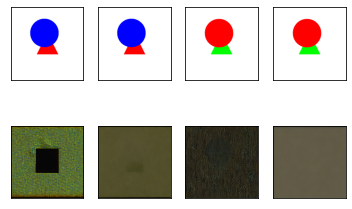

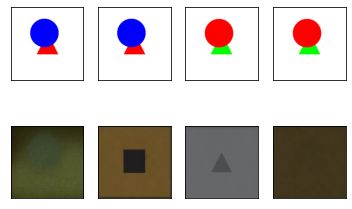

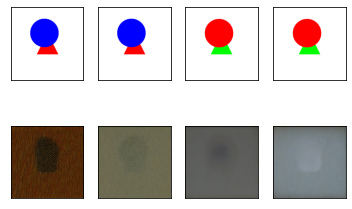

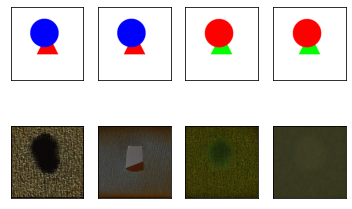

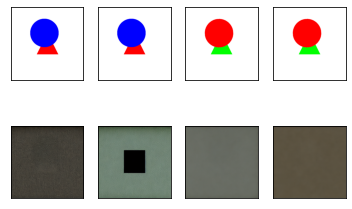

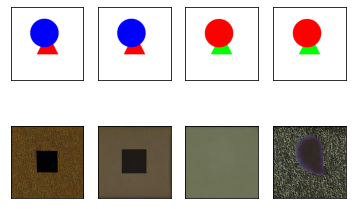

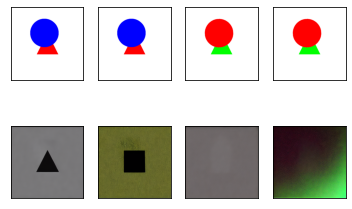

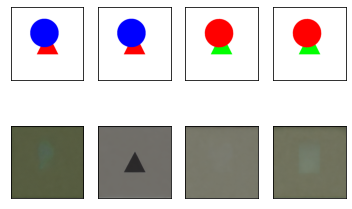

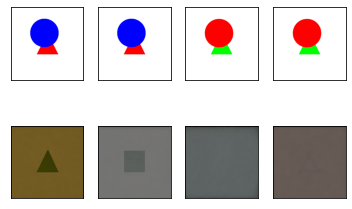

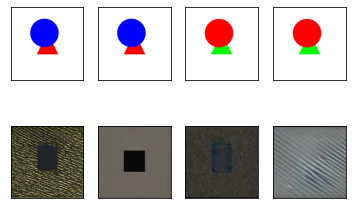

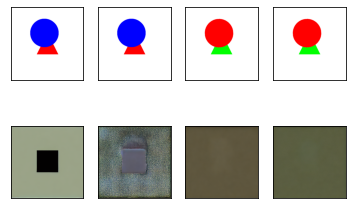

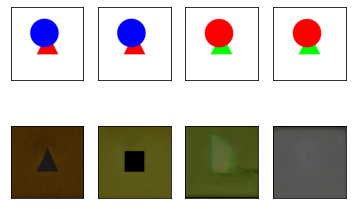

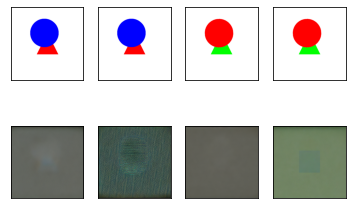

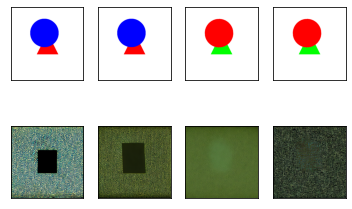

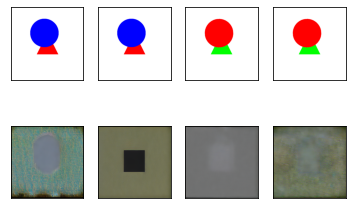

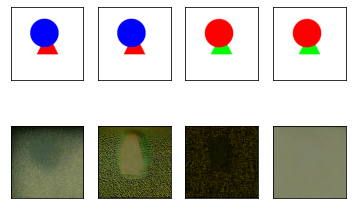

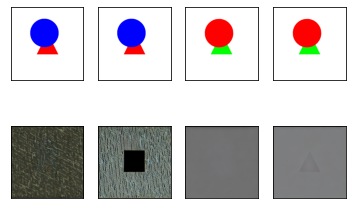

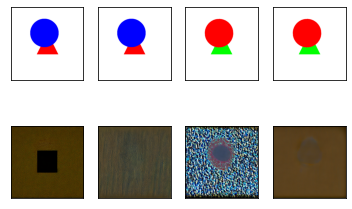

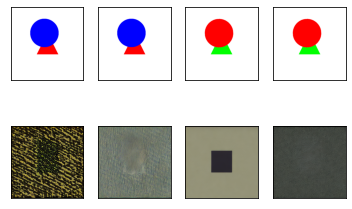

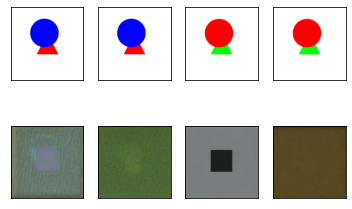

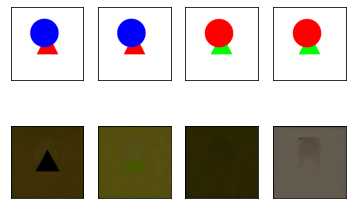

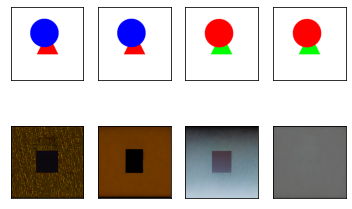

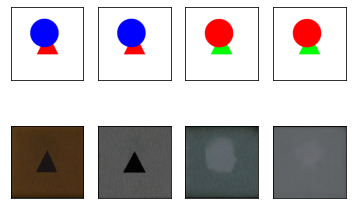

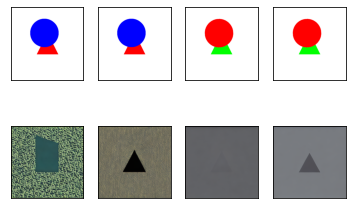

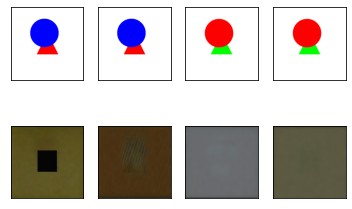

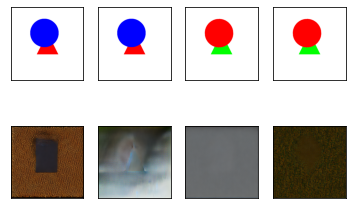

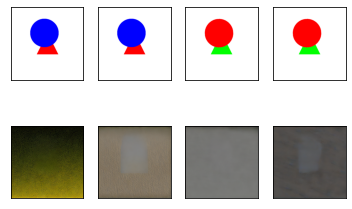

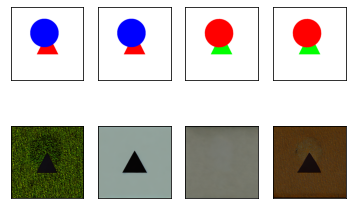

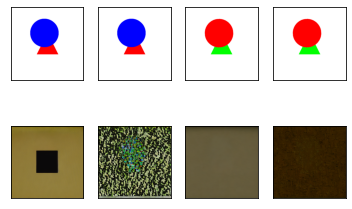

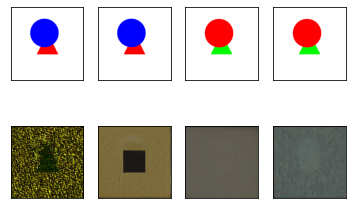

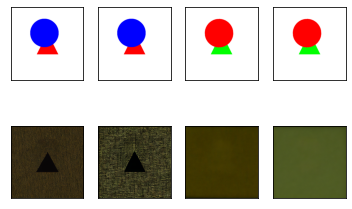

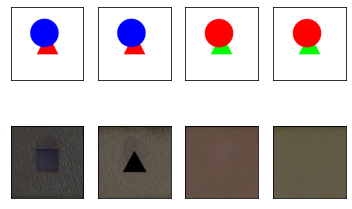

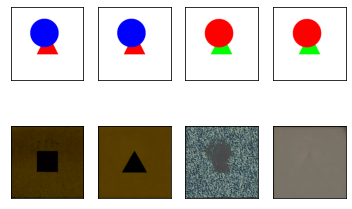

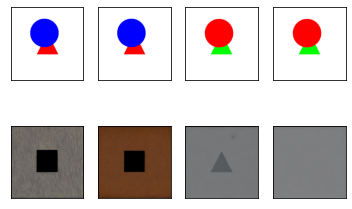

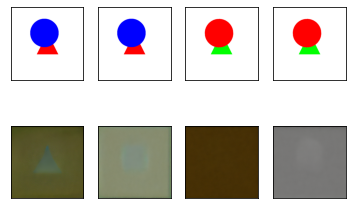

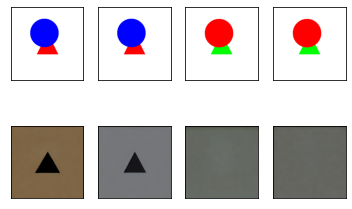

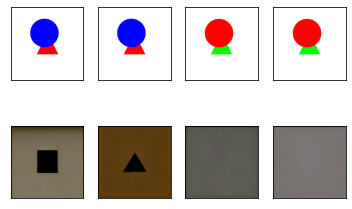

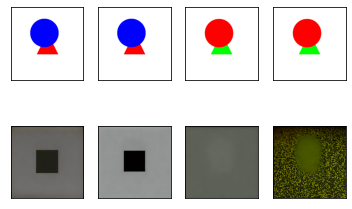

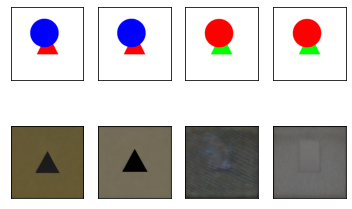

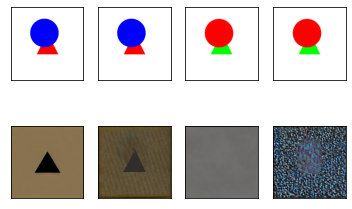

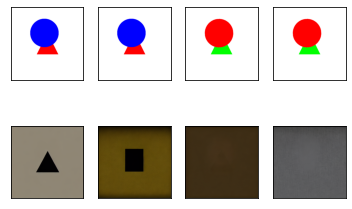

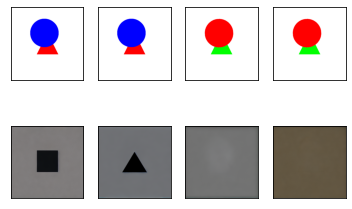

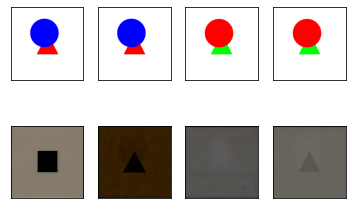

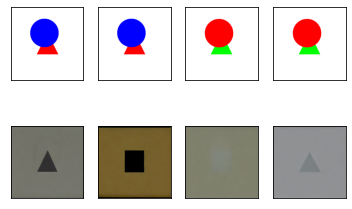

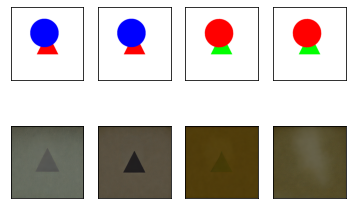

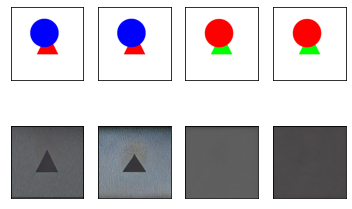

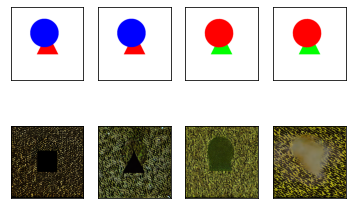

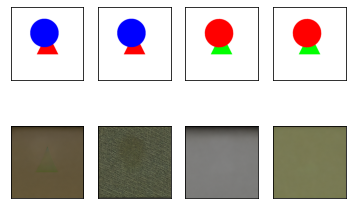

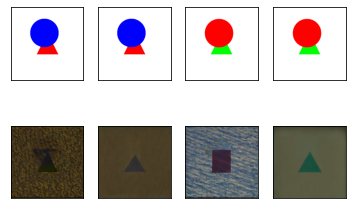

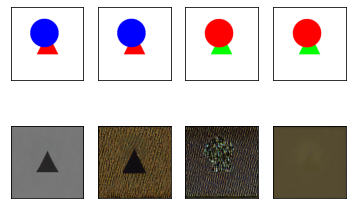

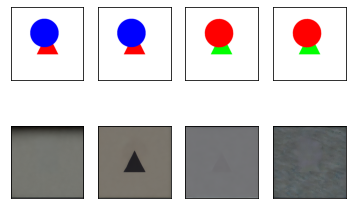

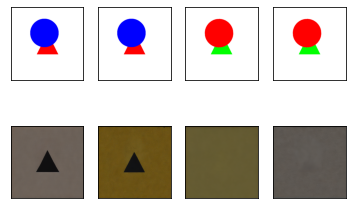

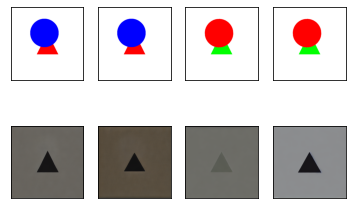

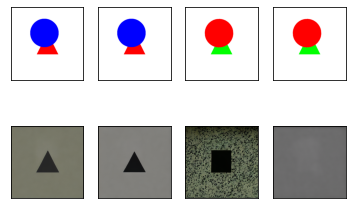

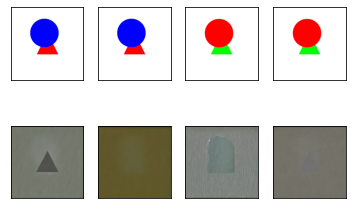

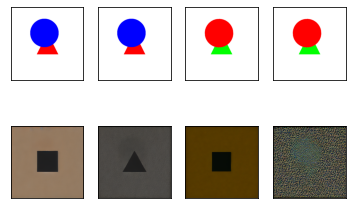

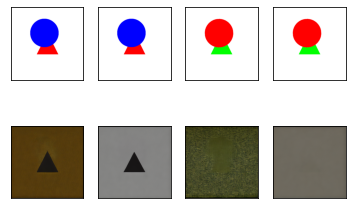

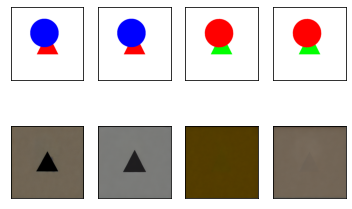

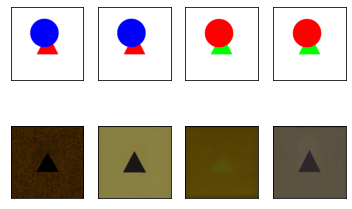

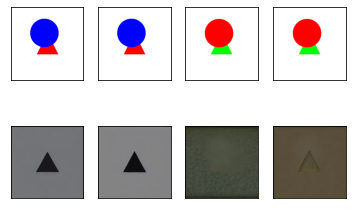

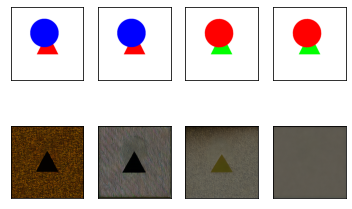

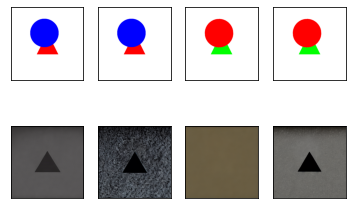

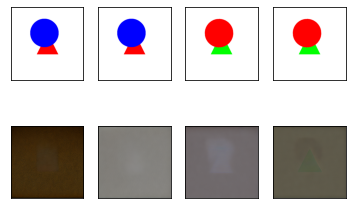

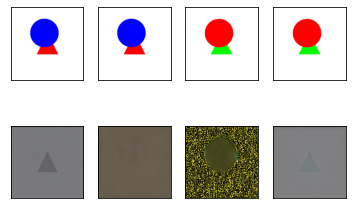

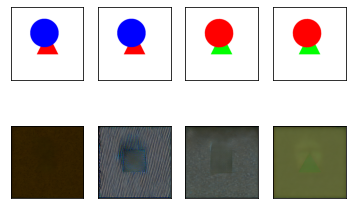

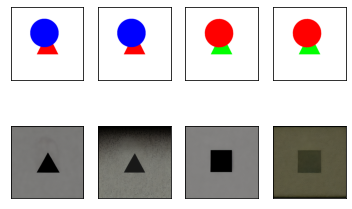

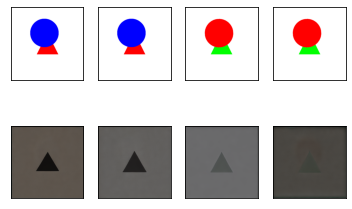

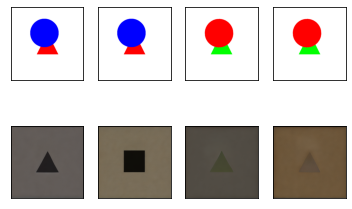

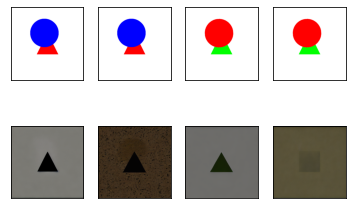

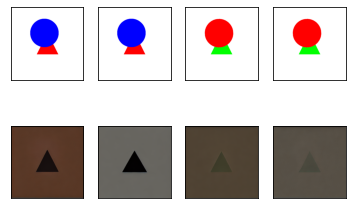

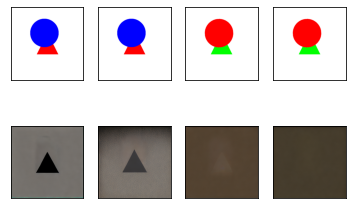

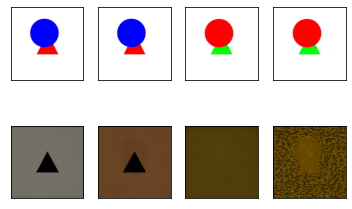

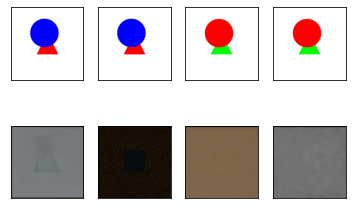

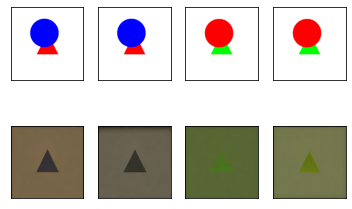

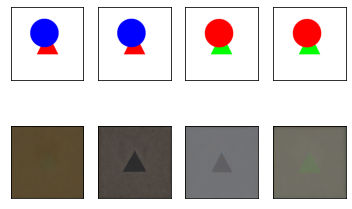

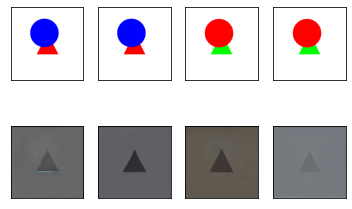

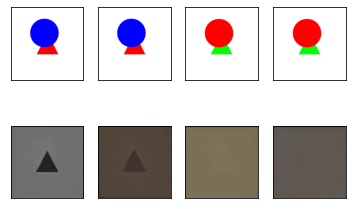

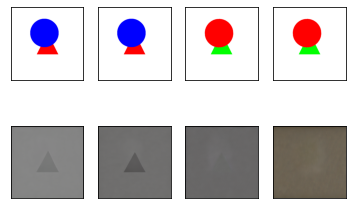

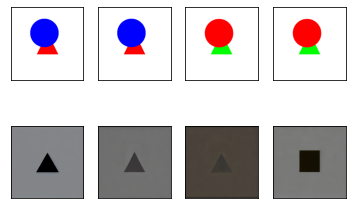

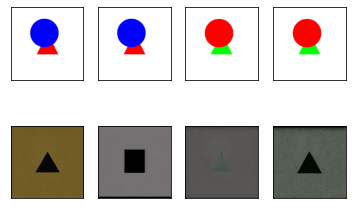

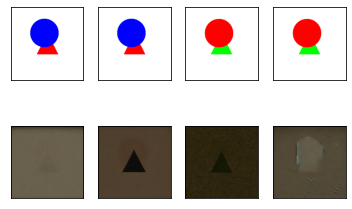

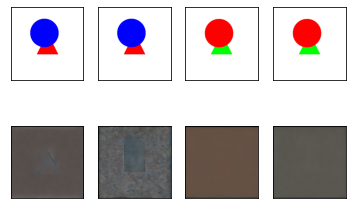

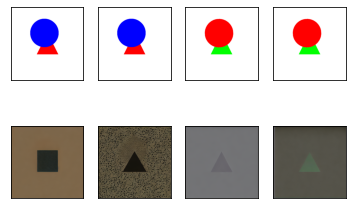

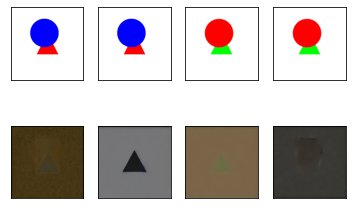

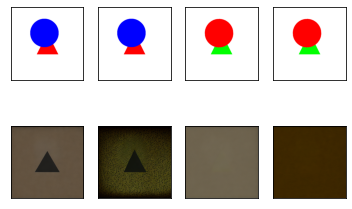

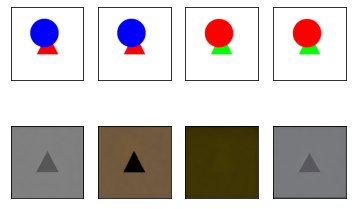

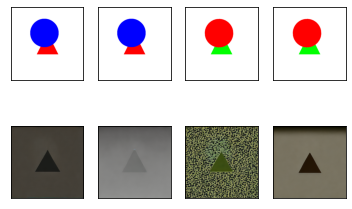

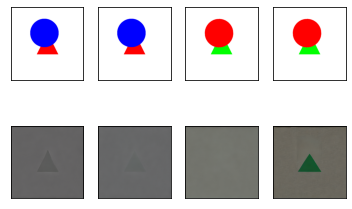

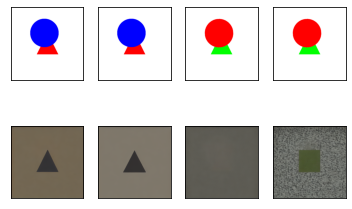

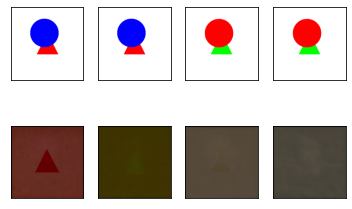

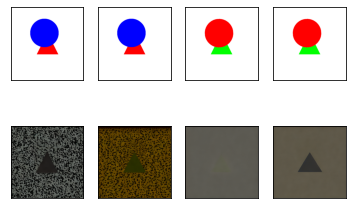

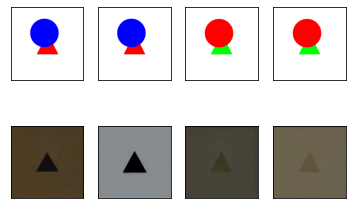

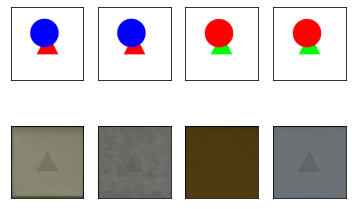

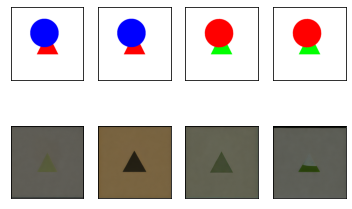

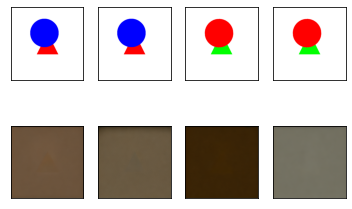

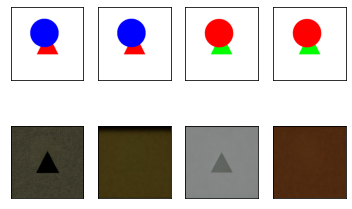

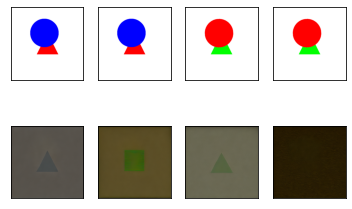

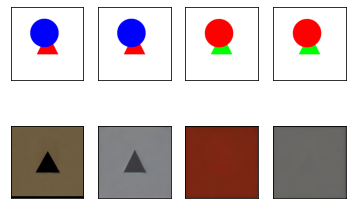

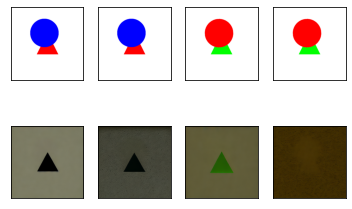

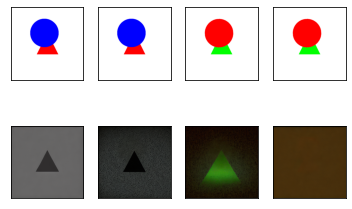

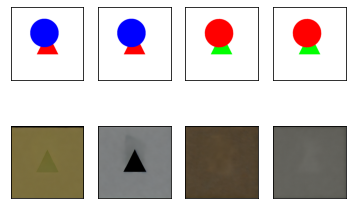

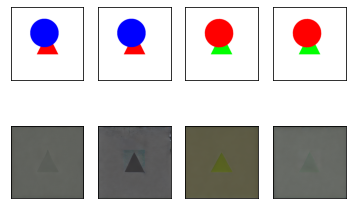

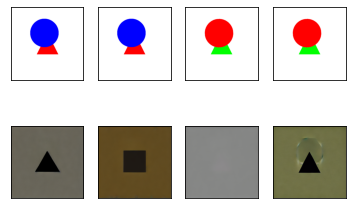

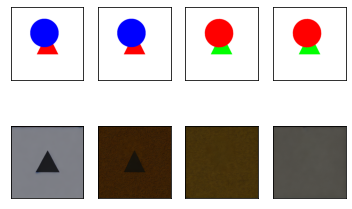

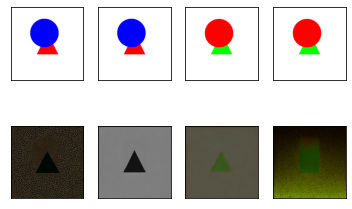

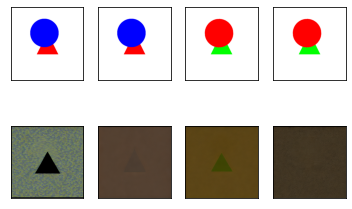

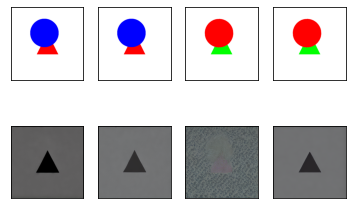

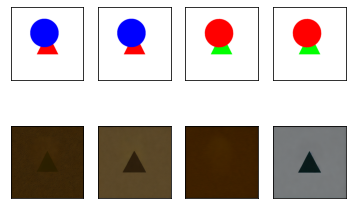

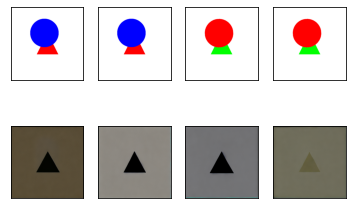

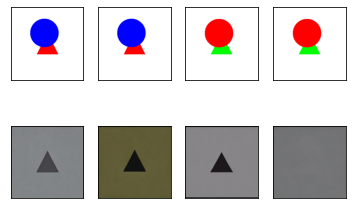

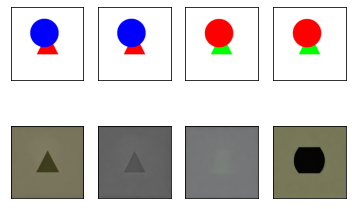

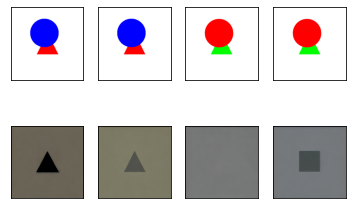

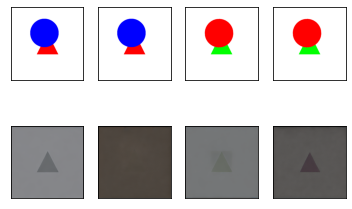

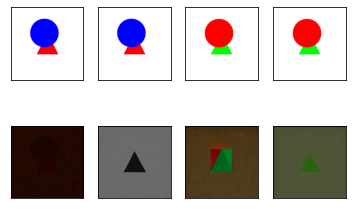

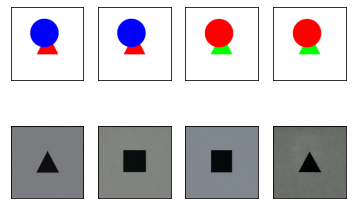

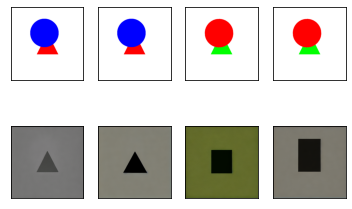

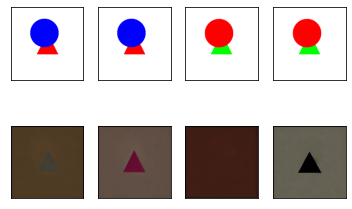

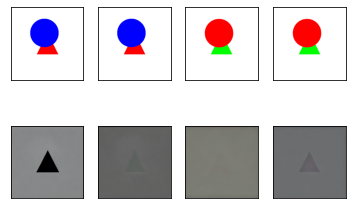

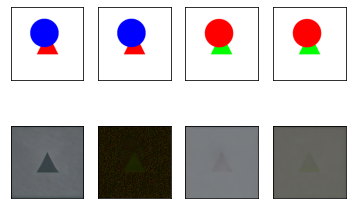

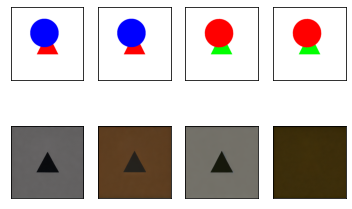

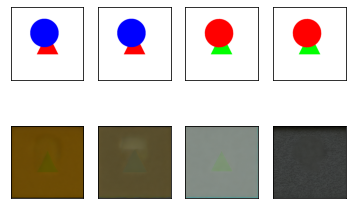

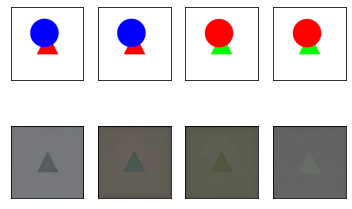

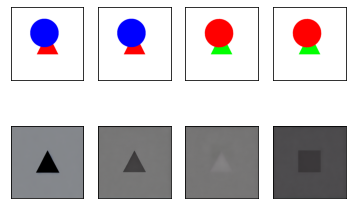

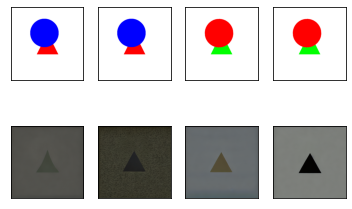

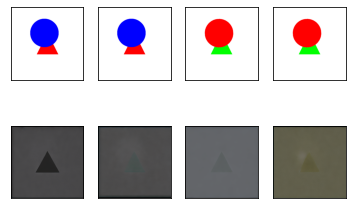

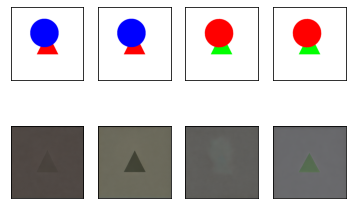

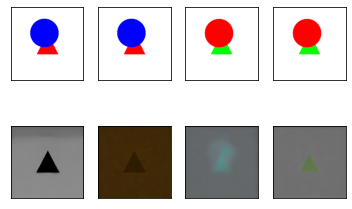

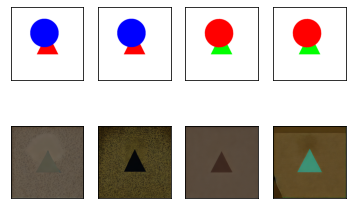

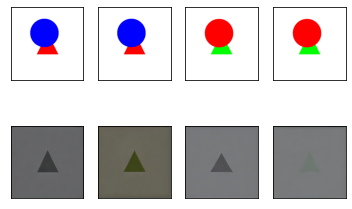

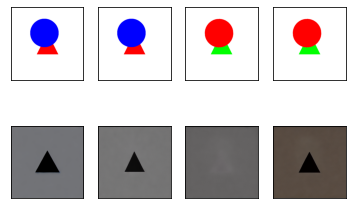

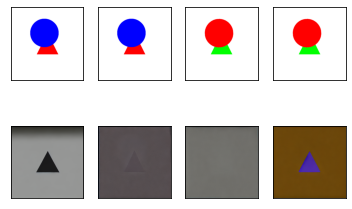

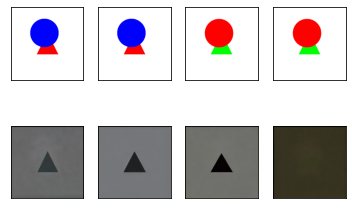

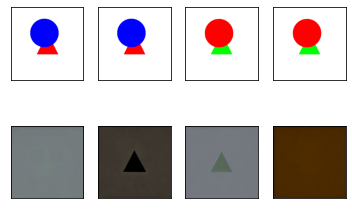

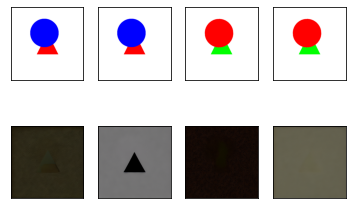

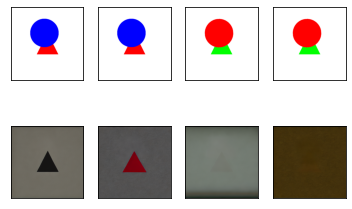

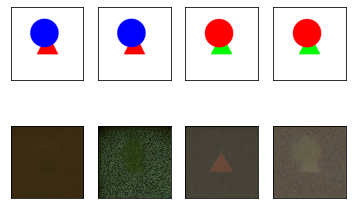

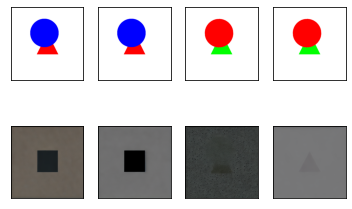

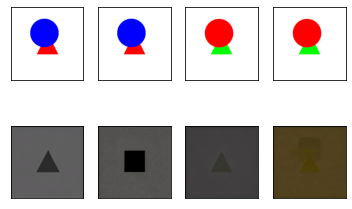

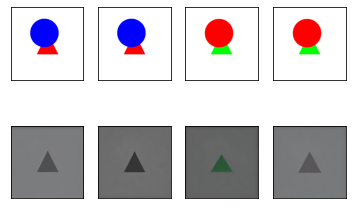

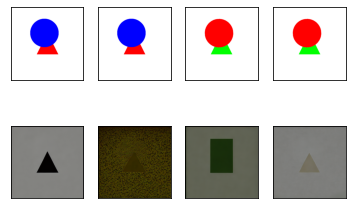

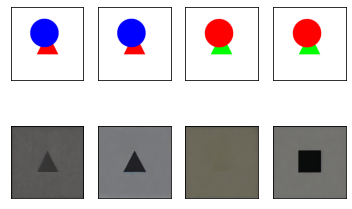

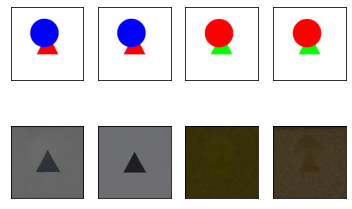

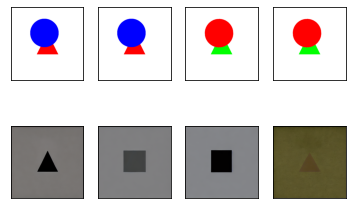

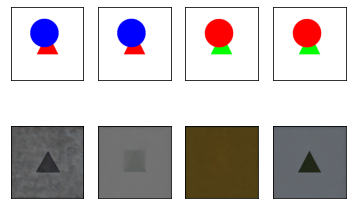

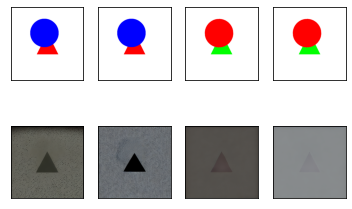

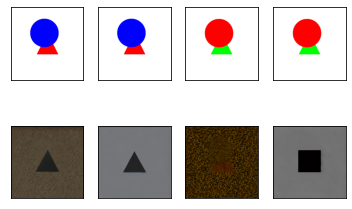

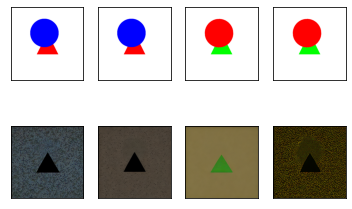

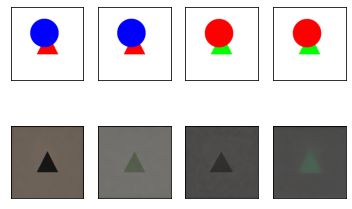

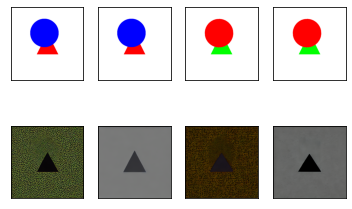

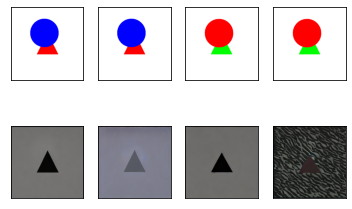

In [29]:
## https://github.com/huggingface/diffusers/blob/main/examples/controlnet/train_controlnet.py
#Set number of max train steps?
torch.autograd.set_detect_anomaly(True)
args.max_train_steps = args.num_train_epochs * len(train_dataloader)


# Train!
total_batch_size = args.train_batch_size #* accelerator.num_processes * args.gradient_accumulation_steps

print("***** Running training *****")
print(f"  Num examples = {len(train_dataset)}")
print(f"  Num batches each epoch = {len(train_dataloader)}")
print(f"  Num Epochs = {args.num_train_epochs}")
print(f"  Instantaneous batch size per device = {args.train_batch_size}")
print(f"  Total train batch size (w. parallel, distributed & accumulation) = {total_batch_size}")
print(f"  Gradient Accumulation steps = {args.gradient_accumulation_steps}")
print(f"  Total optimization steps = {args.max_train_steps}")
global_step = 0
first_epoch = 0

initial_global_step = 0

progress_bar = tqdm(
    range(0, args.max_train_steps),
    initial=initial_global_step,
    desc="Steps",
    # Only show the progress bar once on each machine.
    # disable=not accelerator.is_local_main_process,
)

weight_dtype = torch.float32
image_logs = None
for epoch in range(first_epoch, args.num_train_epochs):
    for step, batch in enumerate(train_dataloader):
        #### Convert images to latent space
        #network that goes from four to three dimensions
        
        # For each batch, we have to get a random layer
        # Generate mask and find polygon for that layer
        #Batch['pixel_values'] will correspond to the polygon for that layer
        rlayer = 0#np.random.randint(3)
        
        latents = vae.encode(batch["pixel_values"][:,rlayer,:].squeeze().to(dtype=weight_dtype).to('cuda')).latent_dist.sample()
        latents = latents * vae.config.scaling_factor
        # print('Latents calculated')
        
        # Sample noise that we'll add to the latents
        noise = torch.randn_like(latents)
        bsz = latents.shape[0]
        # Sample a random timestep for each image
        timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (bsz,), device=latents.device)
        #Following two lines are for uneven sampling (see t2i section 3.4)
        timesteps = (1 - (timesteps/ noise_scheduler.config.num_train_timesteps)**3) *  noise_scheduler.config.num_train_timesteps
        timesteps = timesteps.to(torch.int).clip(0,noise_scheduler.config.num_train_timesteps-1).to(latents.device).long()
        # print(timesteps)
        # timesteps = timesteps.long()
        # print('Noise Generated')

        # Add noise to the latents according to the noise magnitude at each timestep
        # (this is the forward diffusion process)
        noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

        # Get the text embedding for conditioning
        prompt_embeds = pipe._encode_prompt(
            "picture of an object on a black background",
            device="cuda",
            num_images_per_prompt = args.train_batch_size ,
            do_classifier_free_guidance=args.do_classifier_free_guidance,
            negative_prompt=None,
            prompt_embeds=None,
            negative_prompt_embeds=None,
        )
        # print('Prompt Embeddings Generated')

        # Denoising loop
        #We will have two inputs into the adapter, batch{'conditioning_pixel_values'} corresponds to the ground truth image (unchanged)
        # layer_masks = combine_masks(batch['pixel_binaries'],rlayer).repeat(1,3,1,1) #HAD TO ADD  THIS BECAUSE I MESSED UP ONE OF MY MASK DIMENSIONS
        # adapter_input = torch.cat([batch["conditioning_pixel_values"].to(dtype=weight_dtype).to('cuda'), layer_masks.to(dtype=weight_dtype).to('cuda')],dim=1)
        
        adapter_input = batch["conditioning_pixel_values"].to(dtype=weight_dtype).to('cuda')
        adapter_state = adapter(adapter_input) #,adapter_weights = args.adapter_weighting,train=True
        
        # adapter_inputs = [batch["conditioning_pixel_values"].to(dtype=weight_dtype).to('cuda'), 
        #                   layer_masks.to(dtype=weight_dtype).to('cuda')]
        # adapter_state = None
        # for x, adapter in zip(adapter_inputs, adapters):
        #     features = adapter(x)
        #     if adapter_state is None:
        #         adapter_state = features
        #     else:
        #         for i in range(len(features)):
        #             adapter_state[i] + adapter_state[i]+  .5 * features[i]
        
        
        for k, v in enumerate(adapter_state):
            adapter_state[k] = v * args.adapter_conditioning_scale
        if args.num_images_per_prompt > 1:
            for k, v in enumerate(adapter_state):
                adapter_state[k] = v.repeat(args.num_images_per_prompt, 1, 1, 1)
        if args.do_classifier_free_guidance:
            for k, v in enumerate(adapter_state):
                adapter_state[k] = torch.cat([v] * 2, dim=0)
        # print('Adapter values Generated')

        
        ## expand the latents if we are doing classifier free guidance
        latent_model_input = torch.cat([noisy_latents] * 2) if args.do_classifier_free_guidance else noisy_latents

        # predict the noise residual
        noise_pred = unet( 
                latent_model_input,
                timesteps,
                encoder_hidden_states=prompt_embeds,
                cross_attention_kwargs=None,
                down_block_additional_residuals=[state.clone() for state in adapter_state],
        ).sample

        # print('Prediction complete')
        # Get the target for loss depending on the prediction type
        if noise_scheduler.config.prediction_type == "epsilon":
            target = noise
        elif noise_scheduler.config.prediction_type == "v_prediction":
            target = noise_scheduler.get_velocity(latents, noise, timesteps)
        else:
            raise ValueError(f"Unknown prediction type {noise_scheduler.config.prediction_type}")
        loss = F.mse_loss(noise_pred.float(), target.float(), reduction="mean")
        # print('loss computed')
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad(set_to_none=args.set_grads_to_none)
        progress_bar.update(1)

    logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0]}
    print(logs)
    
    progress_bar.set_postfix(**logs)
    if epoch % 1 == 0:
        val_out = log_validation(pipe, adapter, args)
        save_image_logs(val_out,step=epoch)
    if global_step >= args.max_train_steps:
        break

In [ ]:
VALIDATION_SIZE=2
H=W=512

val_binaries = []
val_layers = []
val_imgs = []

def gray2rgb(img):
    return (np.repeat(img,3,-1)* 255).astype(np.uint8)

for itr in range(VALIDATION_SIZE):
    
    #add to lists
    val_binaries.append(masks)
    val_layers.append(polygons)
    val_imgs.append(img)
    
#     if itr%200 == 0:
#         print(itr)

In [ ]:
from PIL import Image

val_imgs_PIL = []
val_layers_PIL = []
for idx in range(len(val_imgs)):
    val_imgs_PIL.append(Image.fromarray((val_imgs[idx]*255).astype(np.uint8)))
    val_layers_PIL.append(Image.fromarray(val_layers[idx][1].astype(np.uint8)))

args.validation_image = val_imgs_PIL
args.validation_prompt = ["picture of an object on a white background"]
args.num_validation_images = VALIDATION_SIZE

In [113]:
img, masks, polygons = generate_overlapping_polygons(H,W,2)
val_img = Image.fromarray((img*255).astype(np.uint8))

In [114]:
with torch.autocast("cuda"):
    image = pipe(args.validation_prompt, val_img, num_inference_steps=40, generator=None).images[0]

  0%|          | 0/40 [00:00<?, ?it/s]

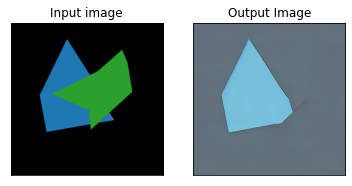

In [115]:
plt.subplot(121)
plt.imshow(img)
plt.xticks([]); plt.yticks([])
plt.title('Input image')

plt.subplot(122)
plt.imshow(image)
plt.title('Output Image')
plt.xticks([]); plt.yticks([]);